In [144]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.decomposition import PCA

In [158]:
# Load data

train = pd.read_table("data/datatraining.txt", sep = ',')
train.index = pd.to_datetime(train.date)
train = train.drop('date', axis = 1)

test = pd.read_table("data/datatest.txt", sep = ",")
test.index = pd.to_datetime(test.date)
test = test.drop('date', axis = 1)

In [159]:
# Remove known anomalies from training data

train = train[train.Occupancy == 0].drop('Occupancy', axis = 1)
test_anomalies = test.Occupancy
test = test.drop('Occupancy', axis = 1)

In [117]:
# Normalize data

norm_train = (train - train.mean()) / train.std()
norm_test = (test - train.mean()) / train.std()

In [118]:
# PCA

pca = PCA(n_components = 2, svd_solver = 'full')

pca_train = pd.DataFrame(pca.fit_transform(norm_train))
pca_train.index = norm_train.index

pca_test = pd.DataFrame(pca.transform(norm_test))
pca_test.index = norm_test.index

In [140]:
# Functions to calculate Mahalanobis Distance

def inv_cov_matrix(x):
    cov = np.cov(x.T)
    if np.all(np.linalg.eigvals(cov) > 0):
        return(np.linalg.inv(cov))

def calculate_M_distance(inv_cov_matrix, means, data):
    diff = data - means
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_cov_matrix).dot(diff[i])))
    return md

def detect_outliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)
    return np.array(outliers)

def calculate_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [141]:
# Find Mahalanobis Distance

x_train = np.array(pca_train.values)
x_test = np.array(pca_test.values)

inv_cov_train = inv_cov_matrix(x_train)

means = x_train.mean(axis=0)

mdist_train = calculate_M_distance(inv_cov_train, means, x_train)
mdist_test = calculate_M_distance(inv_cov_train, means, x_test)

threshold = calculate_threshold(mdist_train, extreme = True)

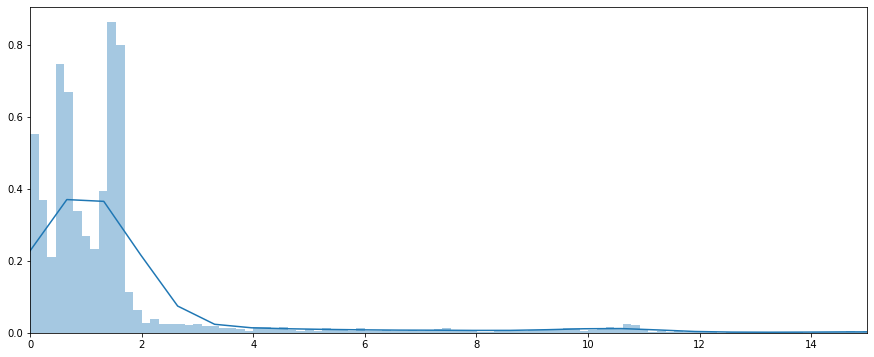

In [175]:
plt.figure(figsize=(15, 6))
sns.distplot(np.square(mdist_train),
             bins = 400)
plt.xlim([0.0,15]);

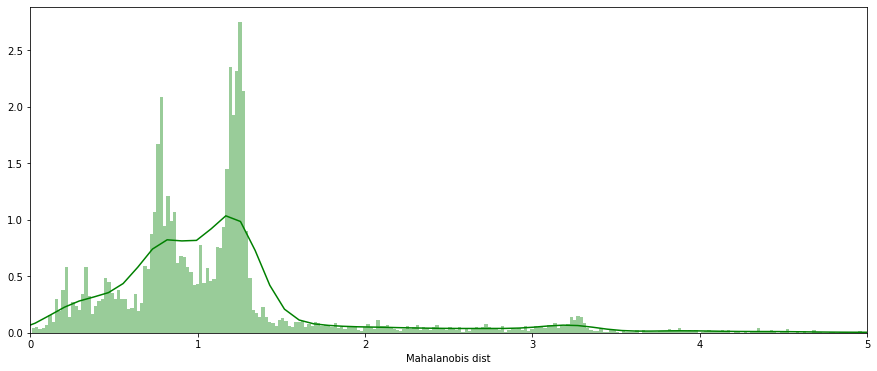

In [174]:
plt.figure(figsize=(15, 6))
sns.distplot(mdist_train,
             bins = 400, 
             color = 'green')
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist');

In [155]:
# Label anomalies

anomaly = pd.DataFrame()
anomaly['Mob dist']= mdist_test
anomaly['Thresh'] = threshold
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = pca_test.index

,Mob dist,Thresh,Anomaly
date,,,
2015-02-02 14:19:00,5.287840,3.487231,True
2015-02-02 14:19:59,5.295002,3.487231,True
2015-02-02 14:21:00,5.297871,3.487231,True
2015-02-02 14:22:00,4.934668,3.487231,True
2015-02-02 14:23:00,4.941577,3.487231,True


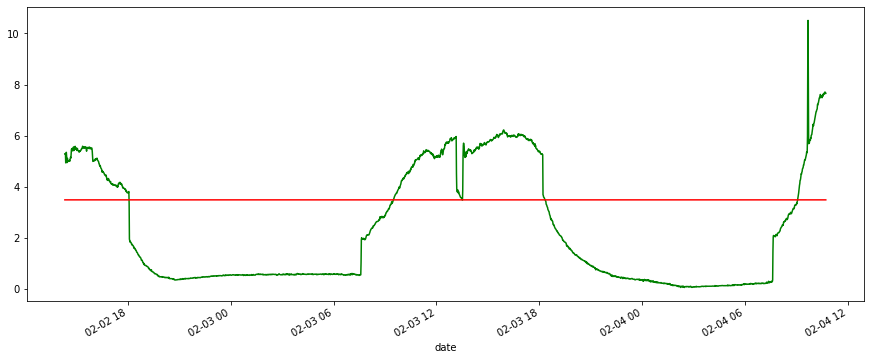

In [179]:
anomaly.plot(figsize = (15,6), color = ['green','red'], legend = False);

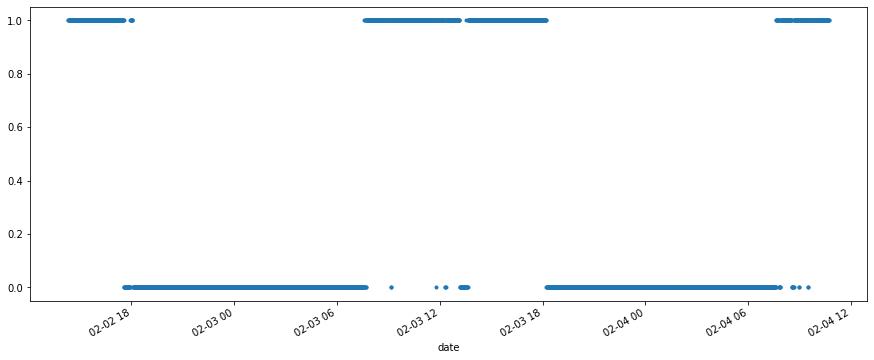

In [181]:
test_anomalies.plot(figsize = (15, 6), style = ".")